In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

simulator = ae353_segbot.Simulator(
    display=True,
    bumpy=False,
)

slider = widgets.FloatSlider(
    value=0.,
    min=-3.,
    max=3.,
    step=0.01,
    description='Centerline:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='75%', border='solid 2px', margin='10px')
)



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
simulator.camera_backview()

from sympy import *
from sympy import *
import numpy as np
from control import acker,ctrb
from scipy import linalg

class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines

        (e_l,
         e_h,
         v,
         w,
         theta,
         thetadot,
         tau_R,
         tau_L) = symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

        w_s = Matrix([[e_l],
                      [e_h],
                      [v],
                      [w],
                      [theta],
                      [thetadot]])

        p_s = Matrix([[tau_R], 
                      [tau_L]])

        f = Matrix([[v*sin(e_h)], 
                    [w], 
                    [-(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)], 
                    [32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))], 
                    [thetadot], 
                    [5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(thetadot**2 + w**2)*sin(theta))*cos(theta) - 76050*sin(theta))/(702*(25*cos(theta)**2 - 26))]])

        #equilibrium point
        w0 = Matrix([[0],
                      [0],
                      [4],
                      [0],
                    [0],
                    [0]])

        p0 = Matrix([[0],
                     [0]])

        #Solving for state-space form
        A_sym = f.jacobian(w_s)
        A = A_sym.subs([(e_l,w0[0]),(e_h,w0[1]),(v,w0[2]),(w,w0[3]),(theta,w0[4]),(thetadot,w0[5]),(tau_R,p0[0]),(tau_L,p0[1])])
        B_sym = f.jacobian(p_s)
        B = B_sym.subs([(e_l,w0[0]),(e_h,w0[1]),(v,w0[2]),(w,w0[3]),(theta,w0[4]),(thetadot,w0[5]),(tau_R,p0[0]),(tau_L,p0[1])])

        A = matrix2numpy(A, dtype=float)
        B = matrix2numpy(B, dtype=float)

        Q = np.array([[4, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 5, 0],
                     [0, 0, 0, 0, 0, 1]])

        #Q associated with Control Inputs

        R = np.array([[1,0],
                   [0,1]])

        P = linalg.solve_continuous_are(A, B, Q, R)

        K = linalg.inv(R) @  B.T @ P
        
        inpt=np.array([[lateral_error],
                 [heading_error],
                 [forward_speed],
                 [turning_rate],
                 [pitch_angle],
                 [pitch_rate]])
        
        x = inpt-w0
        output = -K@x
        
        t_r = output[0]
        t_l = output[1]
        
        if(t_r <= 1 and t_r >= -1):
            right_wheel_torque = t_r
        elif(t_r < -1):
            right_wheel_torque = -1
        else:
            right_wheel_torque = 1
            
        if(t_l <= 1 and t_l >= -1):
            left_wheel_torque = t_l
        elif(t_l < -1):
            left_wheel_torque = -1
        else:
            left_wheel_torque = 1
        return right_wheel_torque, left_wheel_torque

In [3]:
controller = Controller()

simulator.reset(
    initial_speed=4,
    initial_lateral_error=1,
    initial_heading_error=0,
    initial_pitch=0.,
    station_velocity=-0.5,
)

controller.reset()
slider.value = 0.

data = await simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=20.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=None,          # <-- optional (allow no steering)
)

In [9]:
controller = Controller()

simulator.reset(
    initial_speed=4.,
    initial_lateral_error=1.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

controller.reset()
slider.value = 0.

# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border='solid 2px', margin='10px', width='75%'…

Simulated 3001 time steps in 45.5222 seconds (65.9238 time steps per second)


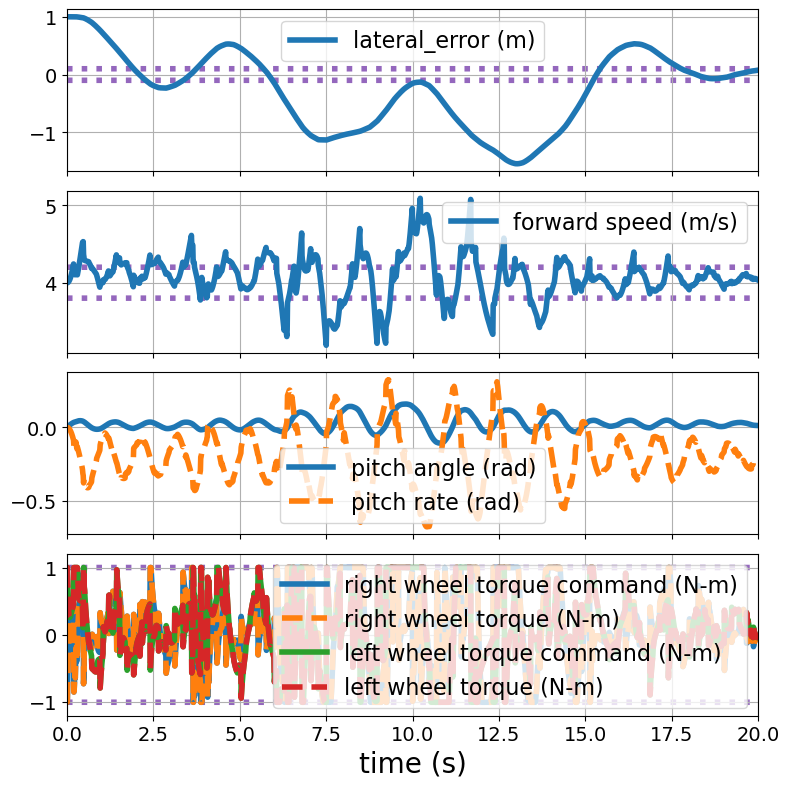

In [5]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], -np.ones_like(data['t']) * 0.1,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_pos.plot(
    data['t'], np.ones_like(data['t']) * 0.1,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], -np.ones_like(data['t']) * 0.2 + 4,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_vel.plot(
    data['t'], np.ones_like(data['t']) * 0.2 + 4,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

In [1]:
from sympy import *
import numpy as np
from control import acker,ctrb
from scipy import linalg
from scipy.linalg import expm
import matplotlib.pyplot as plt

(e_l,
e_h,
v,
w,
theta,
thetadot,
tau_R,
tau_L) = symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

w_s = Matrix([[e_l],
              [e_h],
              [v],
              [w],
              [theta],
              [thetadot]])

p_s = Matrix([[tau_R],
              [tau_L]])

f = Matrix([[v*sin(e_h)],
            [w],
            [-(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)], 
            [32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))], 
            [thetadot], 
            [5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(thetadot**2 + w**2)*sin(theta))*cos(theta) - 76050*sin(theta))/(702*(25*cos(theta)**2 - 26))]])

#equilibrium point
w0 = Matrix([[0],
             [0],
             [4],
             [0],
             [0],
             [0]])

p0 = Matrix([[0],
             [0]])

#Solving for state-space form
A_sym = f.jacobian(w_s)
A = A_sym.subs([(e_l,w0[0]),(e_h,w0[1]),(v,w0[2]),(w,w0[3]),(theta,w0[4]),(thetadot,w0[5]),(tau_R,p0[0]),(tau_L,p0[1])])
B_sym = f.jacobian(p_s)
B = B_sym.subs([(e_l,w0[0]),(e_h,w0[1]),(v,w0[2]),(w,w0[3]),(theta,w0[4]),(thetadot,w0[5]),(tau_R,p0[0]),(tau_L,p0[1])])

A = matrix2numpy(A, dtype=float)
B = matrix2numpy(B, dtype=float)

R = np.array([[1,0],
              [0,1]])

x0 = Matrix([[2],
              [0],
              [4],
              [0],
            [.1],
            [0]])

error = 1E-2

save = np.zeros((6,6))

breakout_flag = False

for a in range(10):
    for b in range(10):
        for c in range(10):
            for d in range(10):
                for e in range(10):
                    for f in range(10):
                        Q = np.array([[f,0,0,0,0,0],
                                      [0,e,0,0,0,0],
                                      [0,0,b,0,0,0],
                                      [0,0,0,a,0,0],
                                      [0,0,0,0,c,0],
                                      [0,0,0,0,0,d]])
                        try:
                            P = linalg.solve_continuous_are(A, B, Q, R)
                        except:
                            continue
                        K = linalg.inv(R) @  B.T @ P
                        M = A-B@K
                        x_10 = expm(M*10)*x0
                        print(x_10)
                        if abs(x_10[0]) <= error and (abs(x_10[4]) <= error):
                            save = Q
                            breakout_flag = True
                            break
                    if breakout_flag:
                        break
                if breakout_flag:
                    break
            if breakout_flag:
                break
        if breakout_flag:
            break
    if breakout_flag:
        break
                            
print(save)

Matrix([[-8.42460486948077e-5], [3.39653247005549e-5], [4.01784092419753], [1.79947687703468e-5], [3.69790985421698e-17], [-8.70936587877409e-20]])
[[2 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


[[ 1.41421356e+00  2.11837536e+00  6.42868616e-16  1.58657585e+00
  -1.07583296e+01 -8.42057908e-01]
 [-1.41421356e+00 -2.11837536e+00  1.25096027e-15 -1.58657585e+00
  -1.07583296e+01 -8.42057908e-01]]
(array([-1.76490633e+00+0.j        , -7.83680576e-01+1.03382744j,
       -7.83680576e-01-1.03382744j, -7.95555026e+01+0.j        ,
       -7.10928915e+00+0.j        , -5.90230583e-16+0.j        ]), array([[-2.69020809e-01+0.00000000e+00j, -1.15030991e-01+4.09978049e-01j,
        -1.15030991e-01-4.09978049e-01j, -2.93607342e-17+0.00000000e+00j,
        -7.12898803e-16+0.00000000e+00j,  2.14992866e-16+0.00000000e+00j],
       [ 4.74796528e-01+0.00000000e+00j, -3.33699002e-01-4.40214028e-01j,
        -3.33699002e-01+4.40214028e-01j, -2.63901132e-17+0.00000000e+00j,
        -3.81552412e-16+0.00000000e+00j, -2.33531039e-26+0.00000000e+00j],
       [-1.21465131e-11+0.00000000e+00j,  8.53399504e-12+1.12595913e-11j,
         8.53399504e-12-1.12595913e-11j, -2.28081076e-01+0.00000000e+00j,
     

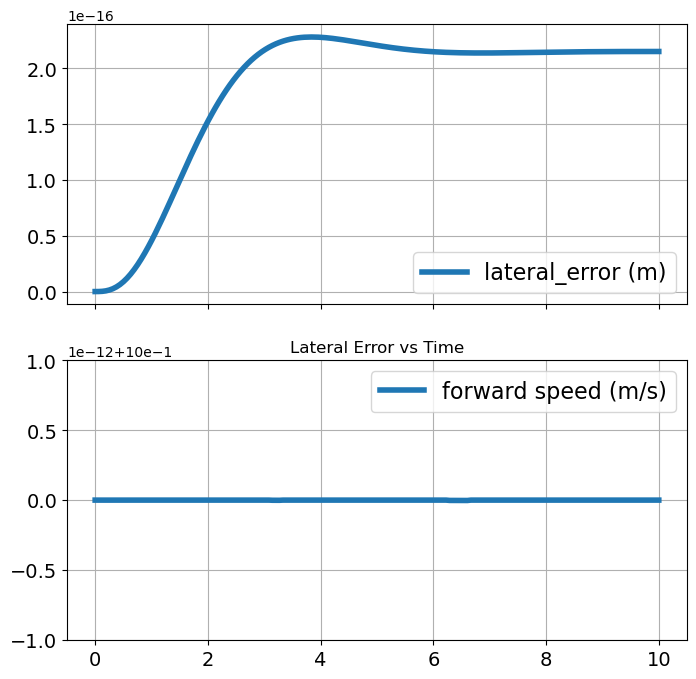

In [23]:
from sympy import *
from sympy import *
import numpy as np
from control import acker,ctrb
from scipy import linalg
from scipy.linalg import expm
import matplotlib.pyplot as plt

(e_l,
e_h,
v,
w,
theta,
thetadot,
tau_R,
tau_L) = symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

w_s = Matrix([[e_l],
              [e_h],
              [v],
              [w],
              [theta],
              [thetadot]])

p_s = Matrix([[tau_R],
              [tau_L]])

f = Matrix([[v*sin(e_h)],
            [w],
            [-(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)], 
            [32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))], 
            [thetadot], 
            [5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(thetadot**2 + w**2)*sin(theta))*cos(theta) - 76050*sin(theta))/(702*(25*cos(theta)**2 - 26))]])

#equilibrium point
w0 = Matrix([[0],
             [0],
             [1],
             [0],
             [0],
             [0]])

p0 = Matrix([[0],
             [0]])

#Solving for state-space form
A_sym = f.jacobian(w_s)
A = A_sym.subs([(e_l,w0[0]),(e_h,w0[1]),(v,w0[2]),(w,w0[3]),(theta,w0[4]),(thetadot,w0[5]),(tau_R,p0[0]),(tau_L,p0[1])])
B_sym = f.jacobian(p_s)
B = B_sym.subs([(e_l,w0[0]),(e_h,w0[1]),(v,w0[2]),(w,w0[3]),(theta,w0[4]),(thetadot,w0[5]),(tau_R,p0[0]),(tau_L,p0[1])])

A = matrix2numpy(A, dtype=float)
B = matrix2numpy(B, dtype=float)

W = ctrb(A,B)

Q = np.array([[4, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 5, 0],
 [0, 0, 0, 0, 0, 1]])

#Q associated with Control Inputs

R = np.array([[1,0],
              [0,1]])

P = linalg.solve_continuous_are(A, B, Q, R)

K = linalg.inv(R) @  B.T @ P

M = A-B@K

print(K)
print(np.linalg.eig(M))

x0 = Matrix([[0],
              [0],
              [1],
              [0],
            [0],
            [0]])
t_r = np.linspace(0,10,160)
x_t = Matrix([])


for i in range(shape(t_r)[0]):
    x_t = x_t.col_insert(i,(expm(M*t_r[i])*x0))
    

# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    t_r, x_t.row(0).T,
    label='lateral_error (m)', linewidth=4,
)
plt.title("Lateral Error vs Time")
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    t_r, x_t.row(2).T,
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

